<a href="https://colab.research.google.com/github/Gofeiyang/ECE661-Project/blob/main/Basic_GAN_Apr25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import basic packages

In [1]:
import functools
import sys
import numpy as np
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import tqdm
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

#Load CIFAR-10 Dataset


In [2]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)


Using downloaded and verified file: ./data/cifar-10-python.tar.gz
Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 输入图像尺寸是 3x32x32
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 下采样至 16x16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 下采样至 8x8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 下采样至 4x4
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # 输出一个单一的数值
        )

    def forward(self, input):
        return self.main(input).view(-1)



In [5]:
def gradient_norm(model):
    norms = []
    for param in model.parameters():
        if param.grad is not None:
            norms.append(param.grad.norm().item())
    return norms

start training Loop.....


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[0/25][0/782]	Loss_D: 1.4221	Loss_G: 1.5371	D(x): 0.5326	D(G(z)): 0.5342 / 0.2208
[0/25][50/782]	Loss_D: 0.2194	Loss_G: 6.0314	D(x): 0.9137	D(G(z)): 0.1173 / 0.0024
[0/25][100/782]	Loss_D: 0.0513	Loss_G: 5.6297	D(x): 0.9675	D(G(z)): 0.0170 / 0.0036
[0/25][150/782]	Loss_D: 0.0965	Loss_G: 5.2665	D(x): 0.9402	D(G(z)): 0.0261 / 0.0054
[0/25][200/782]	Loss_D: 0.5935	Loss_G: 3.6893	D(x): 0.7470	D(G(z)): 0.2181 / 0.0298
[0/25][250/782]	Loss_D: 0.7194	Loss_G: 4.3705	D(x): 0.7820	D(G(z)): 0.3256 / 0.0170
[0/25][300/782]	Loss_D: 0.5094	Loss_G: 3.6673	D(x): 0.7983	D(G(z)): 0.2054 / 0.0365
[0/25][350/782]	Loss_D: 0.9309	Loss_G: 2.0939	D(x): 0.7332	D(G(z)): 0.4161 / 0.1485
[0/25][400/782]	Loss_D: 0.7239	Loss_G: 3.6579	D(x): 0.7643	D(G(z)): 0.3277 / 0.0382
[0/25][450/782]	Loss_D: 0.4999	Loss_G: 2.6693	D(x): 0.7942	D(G(z)): 0.2099 / 0.0879
[0/25][500/782]	Loss_D: 0.7134	Loss_G: 2.1585	D(x): 0.6521	D(G(z)): 0.1584 / 0.1520
[0/25][550/782]	Loss_D: 1.1230	Loss_G: 5.0743	D(x): 0.9008	D(G(z)): 0.5678 / 0.

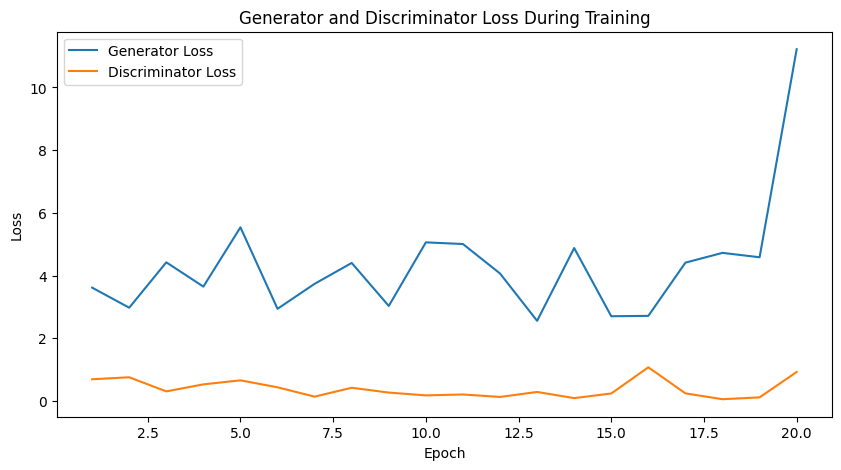

In [97]:
# train the GAN

netG = Generator()
netD = Discriminator()

criterion = nn.BCELoss()
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimize_D = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimize_G = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

netD.to(device)
netG.to(device)

img_list = []

G_losses = []
D_losses = []

gradient_norms_generator = []
gradient_norms_discriminator = []

print('start training Loop.....')
for epoch in range(20):

    for i, data in enumerate(trainloader, 0):
        generator_losses = []
        discriminator_losses = []
        netD.zero_grad()
        # train with real
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        generator_losses.append(gradient_norm(netG))
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        discriminator_losses.append(gradient_norm(netD))
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimize_D.step()

        # train Generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimize_G.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, 25, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        #plot the Epoch loss
    print("the generator loss is:")
    print(generator_losses)
    print("the discriminator loss is:")
    print(discriminator_losses)
    gradient_norms_generator.append(generator_losses)
    gradient_norms_discriminator.append(discriminator_losses)
    G_losses.append(errG.item())
    D_losses.append(errD.item())

def plot_losses(G_losses, D_losses):
    epochs = range(1, len(G_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(epochs, G_losses, label="Generator Loss")
    plt.plot(epochs, D_losses, label="Discriminator Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(G_losses, D_losses)









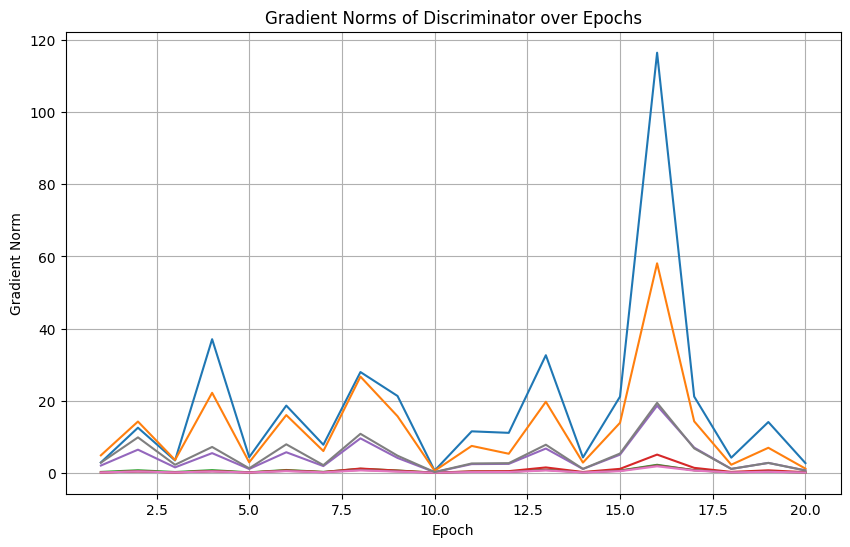

In [100]:
plt.figure(figsize=(10, 6))
for i in range(len(gradient_norms_generator[0])):
    norms = [gradient_norms_discriminator[j][i] for j in range(len(gradient_norms_discriminator))]
    epochs = list(range(1, 21))
    plt.plot(epochs, norms, label=f'Parameter {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient Norm')
    plt.title('Gradient Norms of Discriminator over Epochs')
    plt.grid(True)
    plt.show()


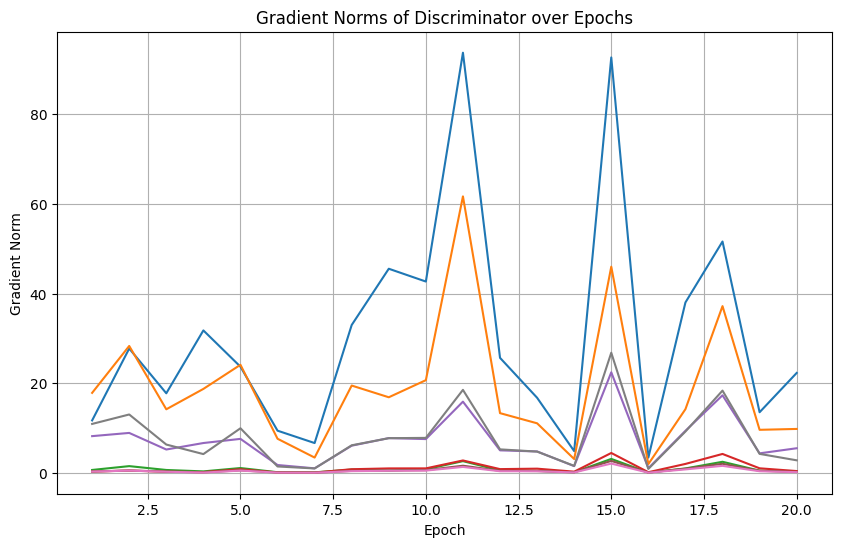

In [10]:
plt.figure(figsize=(10, 6))
for i in range(len(gradient_norms_discriminator[0])):
    norms = [gradient_norms_discriminator[j][i] for j in range(len(gradient_norms_discriminator))]
    epochs = list(range(1, 21))
    plt.plot(epochs, norms, label=f'Parameter {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient Norm')
    plt.title('Gradient Norms of Discriminator over Epochs')
    plt.grid(True)
    plt.show()

Gradient of netG.main.0.weight: 52.366294860839844
Gradient of netG.main.1.weight: 2.919158458709717
Gradient of netG.main.1.bias: 1.7977705001831055
Gradient of netG.main.3.weight: 29.28618812561035
Gradient of netG.main.4.weight: 2.9067564010620117
Gradient of netG.main.4.bias: 2.322679281234741
Gradient of netG.main.6.weight: 41.158729553222656
Gradient of netG.main.7.weight: 3.3509230613708496
Gradient of netG.main.7.bias: 12.300897598266602
Gradient of netG.main.9.weight: 125.56205749511719
Gradient of netD. main.0.weight: 154.16664123535156
Gradient of netD. main.2.weight: 66.21489715576172
Gradient of netD. main.3.weight: 4.31304407119751
Gradient of netD. main.3.bias: 8.167143821716309
Gradient of netD. main.5.weight: 30.221065521240234
Gradient of netD. main.6.weight: 4.28830099105835
Gradient of netD. main.6.bias: 3.153749942779541
Gradient of netD. main.8.weight: 35.380794525146484


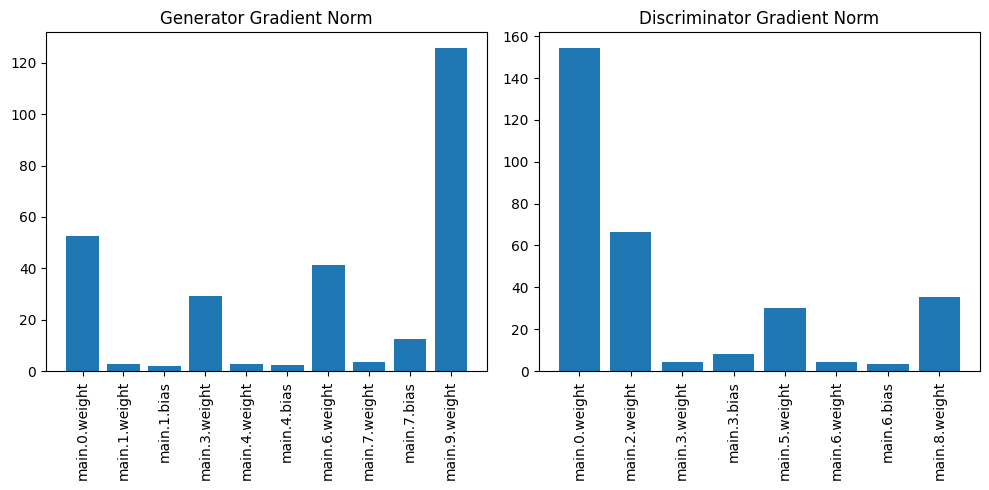

In [11]:
import matplotlib.pyplot as plt
import torch

def plot_gradients(netG, netD):
    # Initialize lists to hold the gradient norms
    #
    g_gradients = {}
    d_gradients = {}

    # Collect gradient norms for each parameter in the generator
    for name, param in netG.named_parameters():
        if param.grad is not None:
            norm = param.grad.data.norm(2).item()  # Convert the norm to a Python float
            print(f"Gradient of netG.{name}: {norm}")
            #record the name and norm
            g_gradients[name] = norm



    # Collect gradient norms for each parameter in the discriminator
    for name, param in netD.named_parameters():
        if param.grad is not None:
            norm = param.grad.data.norm(2).item()  # Convert the norm to a Python float
            print(f"Gradient of netD. {name}: {norm}")
            d_gradients[name] = norm

    # Plotting the gradients
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Generator Gradient Norm")
    #plot the chart
    plt.bar(g_gradients.keys(), g_gradients.values())
    plt.xticks(rotation=90)
    plt.subplot(1, 2, 2)
    plt.title("Discriminator Gradient Norm")
    plt.bar(d_gradients.keys(), d_gradients.values())
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()




# Call the function with the generator and discriminator
plot_gradients(netG, netD)


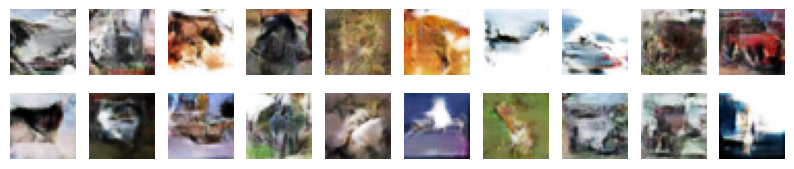

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import torch



n_classes = 10 # CIFAR-10的类别数
n_examples = 2 # 每个类别生成图片的数量

# 生成条件噪声向量
fixed_noise = torch.randn(n_classes * n_examples, 100, 1, 1, device=device) # noise dimension 100

# 为每个类别生成标
labels = torch.arange(n_classes).repeat(n_examples)

# 生成图片
with torch.no_grad():
    netG.eval()
    # 假设你的生成器接受标签作为条件输入
    # 这里需要根据你的具体实现来调整
    fake_images = netG(fixed_noise).detach().cpu()

import matplotlib.pyplot as plt
import numpy as np

# 假定 fake_images, n_classes, n_examples 已经定义

fig = plt.figure(figsize=(10, 2 ))
for i in range(n_classes * n_examples):
    img = fake_images[i] / 2 + 0.5 # 反归一化
    npimg = img.numpy()
    # 交换行列参数以横向展示图像， 每行10张图片，一共两行
    plt.subplot(2, 10, i + 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

#show 20 pictures
plt.show()




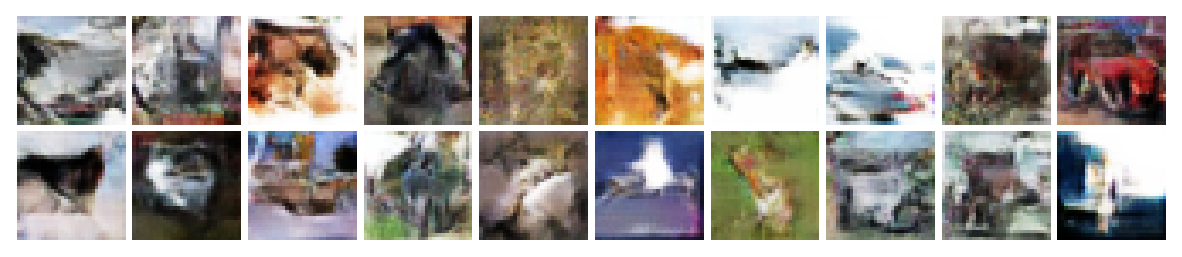

In [34]:
from torchvision.utils import make_grid
def show_images(images, num_images, nrow=10, names=None, name_scale=1):
    plt.figure(figsize=(15 / 10 * nrow, 15))
    images = make_grid(images.cpu()[:num_images], nrow=nrow, padding=2, pad_value=1)
    images =  np.clip(images, 0, 1)
    npimg = images.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    single_img_height = npimg.shape[1] // (num_images // nrow) * name_scale
    if names is not None:
        for i, name in enumerate(names):
            if i >= num_images:
                break  # Break if there are more names than images
            row = i // nrow - 1
            col = i % nrow
            plt.text(col * single_img_height + single_img_height / 2, (row + 1) * single_img_height - single_img_height * 0.14,
                     name, ha='center', va='top', fontsize=12, color='black',
                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='white', boxstyle='round,pad=0.1'))
    plt.show()
show_images(fake_images/ 2 + 0.5, 20)

In [39]:
#plot the Losses vs epochs
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from torchvision.transforms import functional as TF
import numpy as np

def inception_score(images, cuda=True, batch_size=32, resize=False, splits=10):
    """计算 Inception Score.
    参数:
    - images: PyTorch tensor, 大小 [N, 3, H, W]
    - cuda: 是否使用 GPU
    - batch_size: 处理图片的批次大小
    - resize: 是否调整图片为 (299, 299)
    - splits: 计算分数时数据集分割的数量
    """
    N = len(images)
    assert batch_size > 0
    assert N > batch_size

    # 加载 Inception 模型
    inception_model = inception_v3(pretrained=True, transform_input=False)
    inception_model.eval()
    if cuda:
        inception_model.cuda()

    def get_pred(x):
        if resize:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        with torch.no_grad():
            x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    # 计算预测和边缘分布
    preds = np.zeros((N, 1000))

    for i in range(0, N, batch_size):
        batch = images[i:i + batch_size]
        if cuda:
            batch = batch.cuda()
        batch_pred = get_pred(batch)
        preds[i:i + batch_size] = batch_pred

    # 分割数据，计算 Inception Score
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        p_y = np.expand_dims(np.mean(part, axis=0), 0)
        kl_div = part * (np.log(part + 1e-10) - np.log(p_y + 1e-10))
        kl_div = np.mean(np.sum(kl_div, axis=1))
        split_scores.append(np.exp(kl_div))
    return np.mean(split_scores), np.std(split_scores)
# 用法示例
# 假设 `generated_images` 是你的生成图片数据, 形状 [N, 3, H, W]
# is_mean, is_std = inception_score(generated_images, cuda=True, resize=True, batch_size=32)



In [42]:

fake_images = torch.randn(100, 3, 299, 299)
if torch.cuda.is_available():
    fake_images = fake_images.cuda()
score = inception_score(fake_images, cuda=True, resize=True, batch_size=4)
print(score)

(1.0443374867364636, 0.008205377021208653)


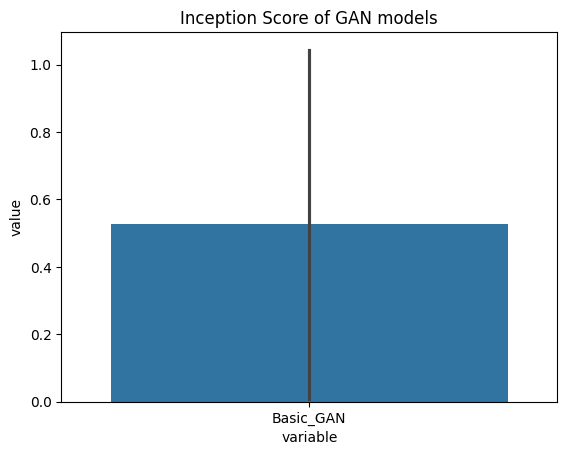

In [43]:
import seaborn as sns
import pandas as pd
import numpy as np
# Create a DataFrame
df = pd.DataFrame({'Basic_GAN': score})
# Melt the DataFrame to long-format
df_long = pd.melt(df, value_vars=['Basic_GAN'])
# Create a bar plot
sns.barplot(x='variable', y='value', data=df_long)
# Set the title
# Optional: Add a title
plt.title('Inception Score of GAN models')

# Show the plot
plt.show()

In [68]:

# netD = Discriminator(conf).to(device)
# Load the weights back into the models
#netG.load_state_dict(torch.load('./netG_basic.pth'))
# netD.load_state_dict(torch.load('netD200.pth'))
# Make sure to call eval() if you're in inference mode
netG.eval()
#save the model
torch.save(netG.state_dict(), 'netG_basic.pth')

In [72]:
n_classes = 10 # CIFAR-10的类别数
n_examples = 50

fixed_noise_500 = torch.randn(n_classes * n_examples, 100, 1, 1, device=device) # noise dimension 100
labels_500 = torch.arange(n_classes).repeat(n_examples)

fake_images_500 = netG(fixed_noise).detach().cpu()

score_500 = inception_score(fake_images_500, cuda=True, resize=True, batch_size=4)
print(score_500)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(2.2622666360700947, 0.26703023201178583)


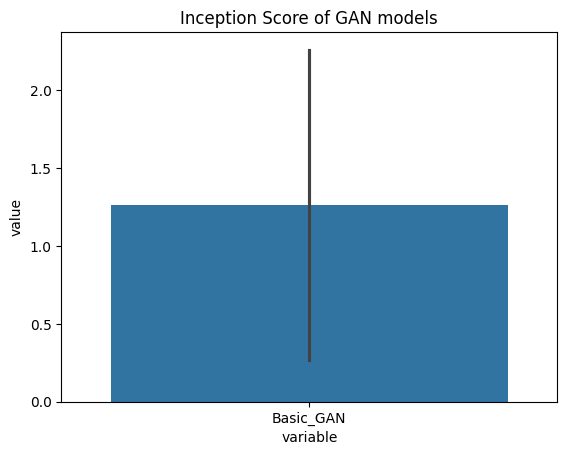

In [73]:
# Create a DataFrame
df = pd.DataFrame({'Basic_GAN': score_500})
# Melt the DataFrame to long-format
df_long = pd.melt(df, value_vars=['Basic_GAN'])
# Create a bar plot
sns.barplot(x='variable', y='value', data=df_long)
# Set the title
# Optional: Add a title
plt.title('Inception Score of GAN models')

# Show the plot
plt.show()


In [74]:
def rgb_to_grayscale_numpy(image):
	"""
	Convert an RGB image to a grayscale image using the luminosity method.
	Parameters:
		image (numpy.ndarray): The RGB image in CHW format.
	Returns:
		numpy.ndarray: The grayscale image in 1HW format (1 channel, Height, Width).
	"""
	if image.shape[0] == 3:  # Check if the input image has 3 channels (RGB)
		image = image.transpose(1, 2, 0)  # Convert to HWC format for easier processing
	# Apply the luminosity method to calculate grayscale values
	grayscale = 0.2989 * image[:, :, 0] + 0.5870 * image[:, :, 1] + 0.1140 * image[:, :, 2]
	return grayscale[np.newaxis, :, :]  # Add channel dimension back for consistency


def calculate_ssim(image1, image2):
	"""
    Calculate the Structural Similarity Index Measure (SSIM) between two images.
    Parameters:
        image1, image2 (numpy.ndarray or torch.Tensor): The input images.
    Returns:
        float: The SSIM index between the two input images.
    """
	# Convert PyTorch tensors to numpy arrays if necessary
	if torch.is_tensor(image1):
		image1 = image1.cpu().numpy()  # CHW to HWC
	if torch.is_tensor(image2):
		image2 = image2.cpu().numpy()  # CHW to HWC
	# Convert images to grayscale
	image1 = rgb_to_grayscale_numpy(image1)[0]
	image2 = rgb_to_grayscale_numpy(image2)[0]
	# Normalize images to ensure they are compared on the same scale
	image1 = (image1 - image1.min()) / (image1.max() - image1.min())
	image2 = (image2 - image2.min()) / (image2.max() - image2.min())
	# Calculate and return the SSIM
	ssim_value = ssim(image1, image2, multichannel=False, data_range=1)
	return ssim_value

In [93]:
from skimage.metrics import structural_similarity as ssim
num_images_acc = 1000  # number of images
fake_noise_1000 = torch.randn(num_images_acc, 100, 1, 1, device=device)
fake_noise_1000_1 = torch.randn(num_images_acc, 100, 1, 1, device=device)
fake_images_1000_1 = netG(fake_noise_1000).detach().cpu()
fake_images_1000_2 = netG(fake_noise_1000_1).detach().cpu()
ssim_scores = []
for gen_img, gen_img2 in zip(fake_images_1000_1, fake_images_1000_2):  # 2 packs pairwise
	current_ssim = calculate_ssim(gen_img, gen_img2)
	ssim_scores.append(current_ssim)

average_ssim_ACGAN = np.mean(ssim_scores)
print(f"Average SSIM (AC-GAN): {average_ssim_ACGAN}")


<ipython-input-74-c264557a9961>:36: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(image1, image2, multichannel=False, data_range=1)


Average SSIM (AC-GAN): 0.042604370344553236


In [94]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

model = models.resnet50(pretrained=True).to(device)
feature_extractor = nn.Sequential(*list(model.children())[:-1])  # Removing the final layer
feature_extractor.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [95]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


def get_features(image, feature_extractor):
	""" Convert image to tensor, normalize, and pass through the model """
	image = normalize(image).unsqueeze(0).to(device)  # Add batch dimension
	with torch.no_grad():
		features = feature_extractor(image)
	return features.flatten()


def cosine_similarity(feat1, feat2):
	""" Compute the cosine similarity between two feature vectors """
	return torch.nn.functional.cosine_similarity(feat1, feat2, dim=0)


def cosine_similarities(features1, features2):
	num_images = len(features1)
	similarities = []
	for i in range(num_images):
		sim = cosine_similarity(features1[i].cpu(), features2[i].cpu())
		similarities.append(sim)
	return similarities


features1 = [get_features(image, feature_extractor) for image in fake_images_1000_1]
features2 = [get_features(image, feature_extractor) for image in fake_images_1000_2]
similarities = cosine_similarities(features1, features2)
average_cosine_ACGAN = np.mean(similarities)
print(f"Average Cosine Similarity (BASCI-GAN): {average_cosine_ACGAN}")

Average Cosine Similarity (BASCI-GAN): 0.8297751545906067


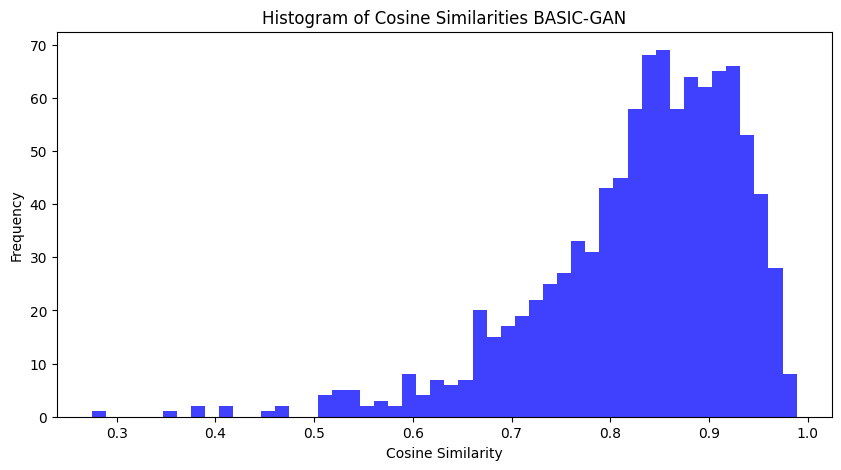

In [96]:
n_bins = 50  # You can change the number of bins based on how detailed you want the histogram to be
plt.figure(figsize=(10, 5))
plt.hist(similarities, bins=n_bins, alpha=0.75, color='blue')
plt.title('Histogram of Cosine Similarities BASIC-GAN')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.show()